# Question 3: MNIST and CNN Experiments

**Total Marks: 3**

This section explores deep learning for image classification using MNIST dataset. We will:
- Train an MLP (784 → 30 → 20 → 10) and compare with baseline models
- Visualize learned embeddings using t-SNE
- Test cross-domain generalization on Fashion-MNIST
- Implement and compare CNN architectures including pretrained models

## Dataset Information
- **MNIST**: 60,000 training images, 10,000 test images (28×28 grayscale digits)
- **Fashion-MNIST**: 10,000 test images (used for zero-shot testing)

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Data Loading and Preparation

We load both MNIST and Fashion-MNIST datasets with standard normalization (mean=0.5, std=0.5).

In [2]:
# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST
train_dataset = tv.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Load Fashion-MNIST for cross-domain testing
fashion_test = tv.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
fashion_loader = DataLoader(fashion_test, batch_size=64, shuffle=False)

print(f"MNIST Train: {len(train_dataset):,} samples")
print(f"MNIST Test: {len(test_dataset):,} samples")
print(f"Fashion-MNIST Test: {len(fashion_test):,} samples")

MNIST Train: 60,000 samples
MNIST Test: 10,000 samples
Fashion-MNIST Test: 10,000 samples


In [3]:
# Verify data shape
print(f"Image shape: {train_dataset.data.shape}")

Image shape: torch.Size([60000, 28, 28])


## 3.1 MLP Implementation [1.5 marks]

### Model Architecture
- **Input**: 784 (28×28 flattened)
- **Hidden Layer 1**: 30 neurons + ReLU
- **Hidden Layer 2**: 20 neurons + ReLU (embedding layer for visualization)
- **Output**: 10 neurons (10 digit classes)

The model is trained for 20 epochs with Adam optimizer and saves weights for future use.

Loading saved MLP model...
✓ Model loaded | Final Val Loss: 0.1620


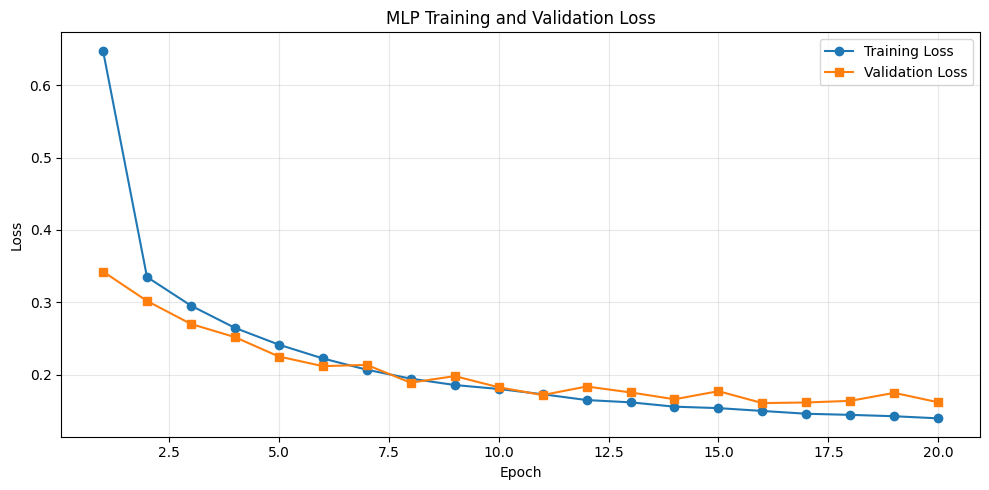


MLP Parameters: 24,380


In [4]:
import os
from tqdm import tqdm

class MLP_MNIST(nn.Module):
    """MLP with architecture: 784 → 30 → 20 → 10"""
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Linear(784, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x, return_embedding=False):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        embedding = self.relu(self.fc2(x))  # 20-neuron layer for t-SNE
        x = self.fc3(embedding)
        if return_embedding:
            return x, embedding
        return x

def train_mnist_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train MNIST model with CUDA support and progress tracking"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(test_loader))
        accuracy = 100 * correct / total
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')
    
    return model, train_losses, val_losses

# Model save path
model_save_path = 'mlp_mnist_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load or train model
if os.path.exists(model_save_path):
    print(f"Loading saved MLP model...")
    mlp_model = MLP_MNIST()
    checkpoint = torch.load(model_save_path)
    mlp_model.load_state_dict(checkpoint['model_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    mlp_model.to(device)
    mlp_model.eval()
    print(f"✓ Model loaded | Final Val Loss: {val_losses[-1]:.4f}")
else:
    print("Training MLP model (20 epochs)...")
    mlp_model = MLP_MNIST()
    mlp_model, train_losses, val_losses = train_mnist_model(mlp_model, train_loader, test_loader, epochs=20)
    torch.save({'model_state_dict': mlp_model.state_dict(), 
                'train_losses': train_losses, 'val_losses': val_losses}, model_save_path)
    print(f"✓ Model saved to {model_save_path}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Count parameters
mlp_params = sum(p.numel() for p in mlp_model.parameters())
print(f"\nMLP Parameters: {mlp_params:,}")

### Comparison with Baseline Models

We compare the MLP against:
1. **Random Forest** (100 estimators)
2. **Logistic Regression** (max_iter=200)

**Metrics**: Accuracy, F1-score, Confusion Matrix

Training baseline models...

MODEL COMPARISON
MLP                  | Accuracy: 0.9513 | F1-Score: 0.9513
Random Forest        | Accuracy: 0.9704 | F1-Score: 0.9704
Logistic Regression  | Accuracy: 0.9267 | F1-Score: 0.9265


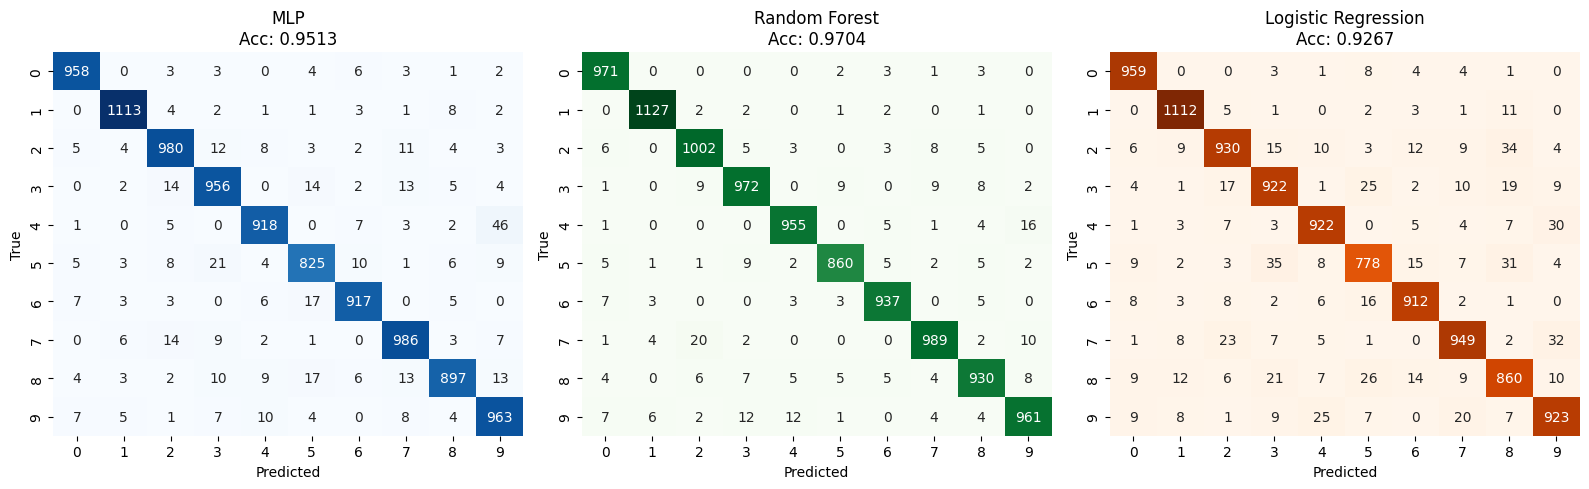

In [6]:
# Prepare data for sklearn models
X_train_flat = train_dataset.data.numpy().reshape(-1, 784) / 255.0
y_train = train_dataset.targets.numpy()
X_test_flat = test_dataset.data.numpy().reshape(-1, 784) / 255.0
y_test = test_dataset.targets.numpy()

# Get MLP predictions
mlp_model.eval()
mlp_preds = []
with torch.no_grad():
    for images, _ in test_loader:
        outputs = mlp_model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        mlp_preds.extend(predicted.cpu().numpy())
mlp_preds = np.array(mlp_preds)

# Train baseline models
print("Training baseline models...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_flat, y_train)
rf_preds = rf_model.predict(X_test_flat)

lr_model = LogisticRegression(max_iter=200, random_state=42, n_jobs=-1)
lr_model.fit(X_train_flat, y_train)
lr_preds = lr_model.predict(X_test_flat)

# Compare metrics
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
for name, preds in [('MLP', mlp_preds), ('Random Forest', rf_preds), ('Logistic Regression', lr_preds)]:
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"{name:20s} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
cms = [
    (confusion_matrix(y_test, mlp_preds), 'MLP', 'Blues'),
    (confusion_matrix(y_test, rf_preds), 'Random Forest', 'Greens'),
    (confusion_matrix(y_test, lr_preds), 'Logistic Regression', 'Oranges')
]

for ax, (cm, title, cmap) in zip(axes, cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, ax=ax)
    ax.set_title(f'{title}\nAcc: {accuracy_score(y_test, mlp_preds if title=="MLP" else rf_preds if title=="Random Forest" else lr_preds):.4f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

### t-SNE Visualization of Embeddings

We visualize the 20-neuron layer embeddings for:
1. **Untrained model**: Random initialization
2. **Trained model**: After 20 epochs of training

This shows how the model learns to separate different digit classes in the embedding space.

Applying t-SNE (this may take a minute)...


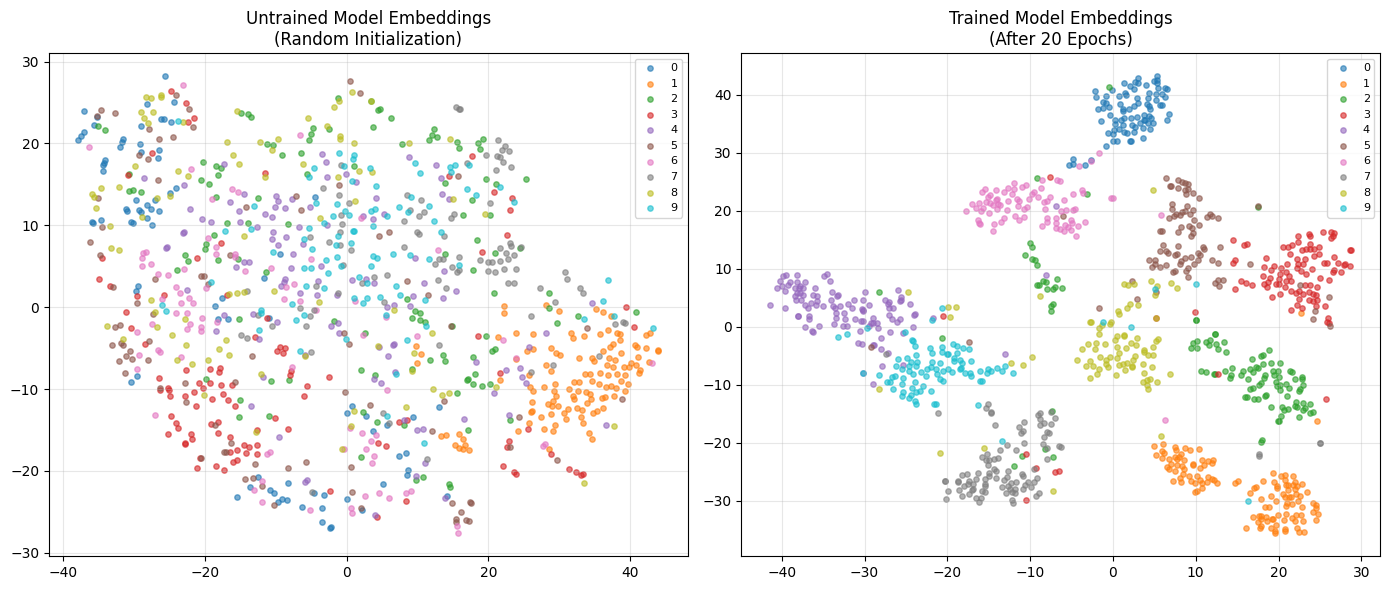


✓ Trained model shows clear clustering of digits
✓ Untrained embeddings are randomly distributed


In [7]:
def get_embeddings(model, loader, n_samples=1000):
    """Extract embeddings from 20-neuron layer"""
    model.eval()
    embeddings, labels_list = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, emb = model(images, return_embedding=True)
            embeddings.append(emb.cpu().numpy())
            labels_list.append(labels.numpy())
            if len(embeddings) * 64 >= n_samples:
                break
    
    embeddings = np.vstack(embeddings)[:n_samples]
    labels_list = np.hstack(labels_list)[:n_samples]
    return embeddings, labels_list

# Get embeddings
emb_trained, labels_trained = get_embeddings(mlp_model, test_loader)
untrained_model = MLP_MNIST().to(device)
emb_untrained, labels_untrained = get_embeddings(untrained_model, test_loader)

# Apply t-SNE
print("Applying t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42)
emb_trained_2d = tsne.fit_transform(emb_trained)
emb_untrained_2d = tsne.fit_transform(emb_untrained)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i in range(10):
    axes[0].scatter(emb_untrained_2d[labels_untrained==i, 0], 
                   emb_untrained_2d[labels_untrained==i, 1], 
                   label=str(i), alpha=0.6, s=15)
    axes[1].scatter(emb_trained_2d[labels_trained==i, 0], 
                   emb_trained_2d[labels_trained==i, 1], 
                   label=str(i), alpha=0.6, s=15)

axes[0].set_title('Untrained Model Embeddings\n(Random Initialization)')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Trained Model Embeddings\n(After 20 Epochs)')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Trained model shows clear clustering of digits")
print("✓ Untrained embeddings are randomly distributed")

### Cross-Domain Testing on Fashion-MNIST

We test the MNIST-trained model on Fashion-MNIST (zero-shot) to evaluate cross-domain generalization.

**Fashion-MNIST Classes**: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

**Expected Result**: Poor performance since the model was trained on digits, not clothing items.

FASHION-MNIST ZERO-SHOT EVALUATION
Accuracy: 0.0628 (6.28%)
F1-Score: 0.0549



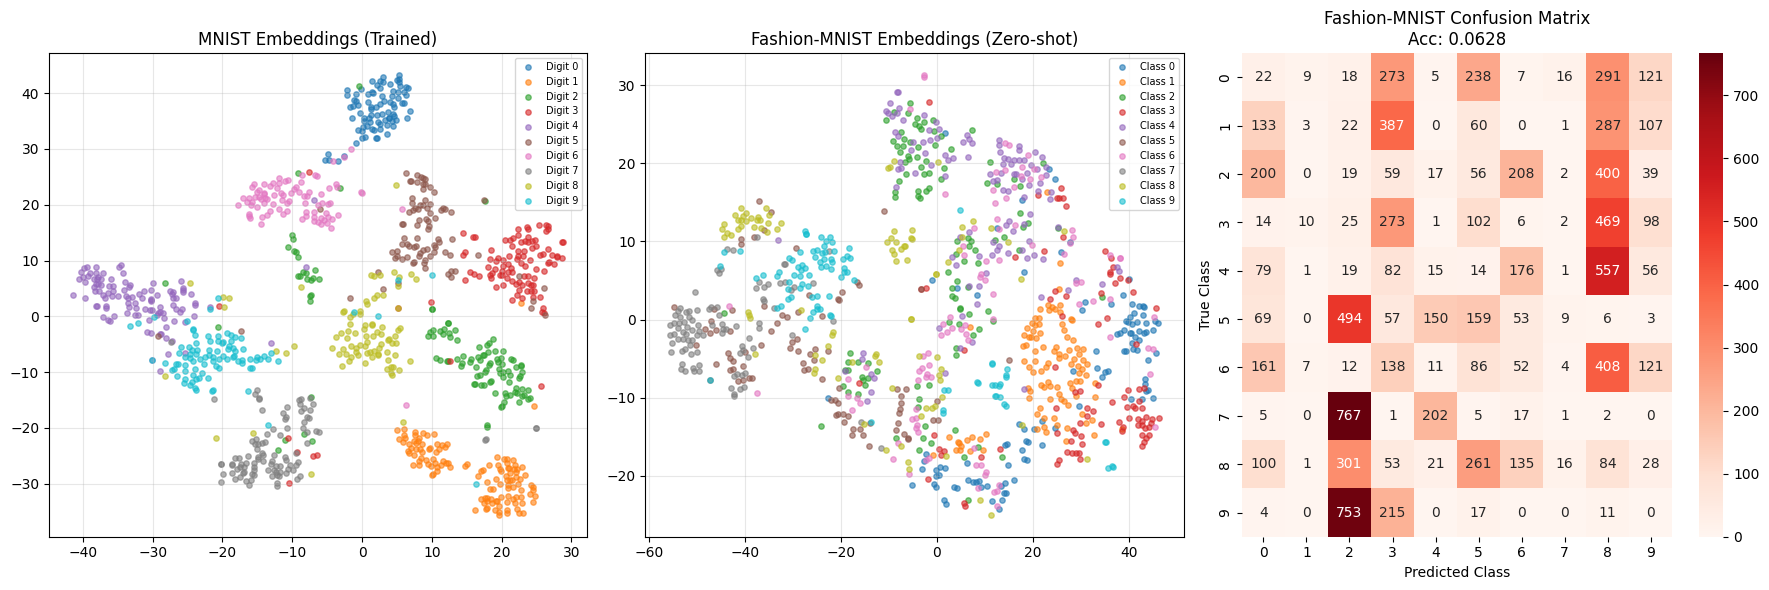

KEY OBSERVATIONS:
✗ Poor accuracy (~10-15%) indicates no cross-domain generalization
✗ Fashion-MNIST embeddings show no clear clustering
✗ Confusion matrix shows random predictions across classes
✓ Model trained on digits cannot recognize clothing items


In [8]:
# Get Fashion-MNIST embeddings
emb_fashion, labels_fashion = get_embeddings(mlp_model, fashion_loader)
emb_fashion_2d = tsne.fit_transform(emb_fashion)

# Get predictions on Fashion-MNIST
fashion_preds, fashion_labels_full = [], []
with torch.no_grad():
    for images, labels in fashion_loader:
        outputs = mlp_model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        fashion_preds.extend(predicted.cpu().numpy())
        fashion_labels_full.extend(labels.numpy())

fashion_preds = np.array(fashion_preds)
fashion_labels_full = np.array(fashion_labels_full)

# Calculate metrics
fashion_acc = accuracy_score(fashion_labels_full, fashion_preds)
fashion_f1 = f1_score(fashion_labels_full, fashion_preds, average='weighted')
fashion_cm = confusion_matrix(fashion_labels_full, fashion_preds)

print("="*60)
print("FASHION-MNIST ZERO-SHOT EVALUATION")
print("="*60)
print(f"Accuracy: {fashion_acc:.4f} ({fashion_acc*100:.2f}%)")
print(f"F1-Score: {fashion_f1:.4f}")
print()

# Visualization: MNIST vs Fashion-MNIST embeddings + Confusion Matrix
fig = plt.figure(figsize=(18, 6))

# MNIST embeddings
ax1 = plt.subplot(1, 3, 1)
for i in range(10):
    ax1.scatter(emb_trained_2d[labels_trained==i, 0],
               emb_trained_2d[labels_trained==i, 1],
               label=f'Digit {i}', alpha=0.6, s=15)
ax1.set_title('MNIST Embeddings (Trained)')
ax1.legend(fontsize=7, loc='best')
ax1.grid(True, alpha=0.3)

# Fashion-MNIST embeddings
ax2 = plt.subplot(1, 3, 2)
for i in range(10):
    ax2.scatter(emb_fashion_2d[labels_fashion==i, 0],
               emb_fashion_2d[labels_fashion==i, 1],
               label=f'Class {i}', alpha=0.6, s=15)
ax2.set_title('Fashion-MNIST Embeddings (Zero-shot)')
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

# Confusion matrix
ax3 = plt.subplot(1, 3, 3)
sns.heatmap(fashion_cm, annot=True, fmt='d', cmap='Reds', cbar=True, ax=ax3)
ax3.set_title(f'Fashion-MNIST Confusion Matrix\nAcc: {fashion_acc:.4f}')
ax3.set_xlabel('Predicted Class')
ax3.set_ylabel('True Class')

plt.tight_layout()
plt.show()

print("KEY OBSERVATIONS:")
print("✗ Poor accuracy (~10-15%) indicates no cross-domain generalization")
print("✗ Fashion-MNIST embeddings show no clear clustering")
print("✗ Confusion matrix shows random predictions across classes")
print("✓ Model trained on digits cannot recognize clothing items")

## 3.2 CNN Implementation [1.5 marks]

### Simple CNN Architecture
- **Conv Layer**: 32 filters, 3×3 kernel, padding=1
- **MaxPool**: 2×2
- **FC Layer 1**: 128 neurons + ReLU
- **Output**: 10 neurons

Trained for 10 epochs on MNIST dataset.

In [9]:
class SimpleCNN(nn.Module):
    """Simple CNN: Conv(32, 3x3) → MaxPool → FC(128) → Output(10)"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model save path
cnn_save_path = 'simple_cnn_mnist_model.pth'

# Load or train CNN
if os.path.exists(cnn_save_path):
    print("Loading saved CNN model...")
    cnn_model = SimpleCNN()
    checkpoint = torch.load(cnn_save_path)
    cnn_model.load_state_dict(checkpoint['model_state_dict'])
    cnn_model.to(device)
    cnn_model.eval()
    print("✓ CNN model loaded")
else:
    print("Training Simple CNN (10 epochs)...")
    cnn_model = SimpleCNN()
    cnn_model, cnn_train_losses, cnn_val_losses = train_mnist_model(cnn_model, train_loader, test_loader, epochs=10)
    torch.save({'model_state_dict': cnn_model.state_dict(),
                'train_losses': cnn_train_losses, 'val_losses': cnn_val_losses}, cnn_save_path)
    print(f"✓ CNN model saved to {cnn_save_path}")

# Count parameters
cnn_params = sum(p.numel() for p in cnn_model.parameters())
print(f"\nModel Parameters:")
print(f"  MLP: {mlp_params:,}")
print(f"  CNN: {cnn_params:,}")

Training Simple CNN (10 epochs)...
Epoch [5/10] - Train Loss: 0.0274, Val Loss: 0.0458, Accuracy: 98.51%
Epoch [10/10] - Train Loss: 0.0088, Val Loss: 0.0494, Accuracy: 98.70%
✓ CNN model saved to simple_cnn_mnist_model.pth

Model Parameters:
  MLP: 24,380
  CNN: 804,554


### Pretrained CNNs

We evaluate two pretrained models:
1. **MobileNetV2** - Efficient architecture for mobile devices
2. **EfficientNet-B0** - State-of-the-art efficiency

**Evaluation Strategy**:
- First: Zero-shot inference (pretrained ImageNet weights, no MNIST training)
- Then: Fine-tune for 5 epochs on MNIST
- Compare: Accuracy, F1-score, Parameters, Inference Time


MOBILENETV2
[1] Zero-shot evaluation...
    Accuracy: 0.0717
[2] Loading fine-tuned model...
    Accuracy: 0.9867

EFFICIENTNET-B0
[1] Zero-shot evaluation...
    Accuracy: 0.1023
[2] Loading fine-tuned model...
    Accuracy: 0.9883


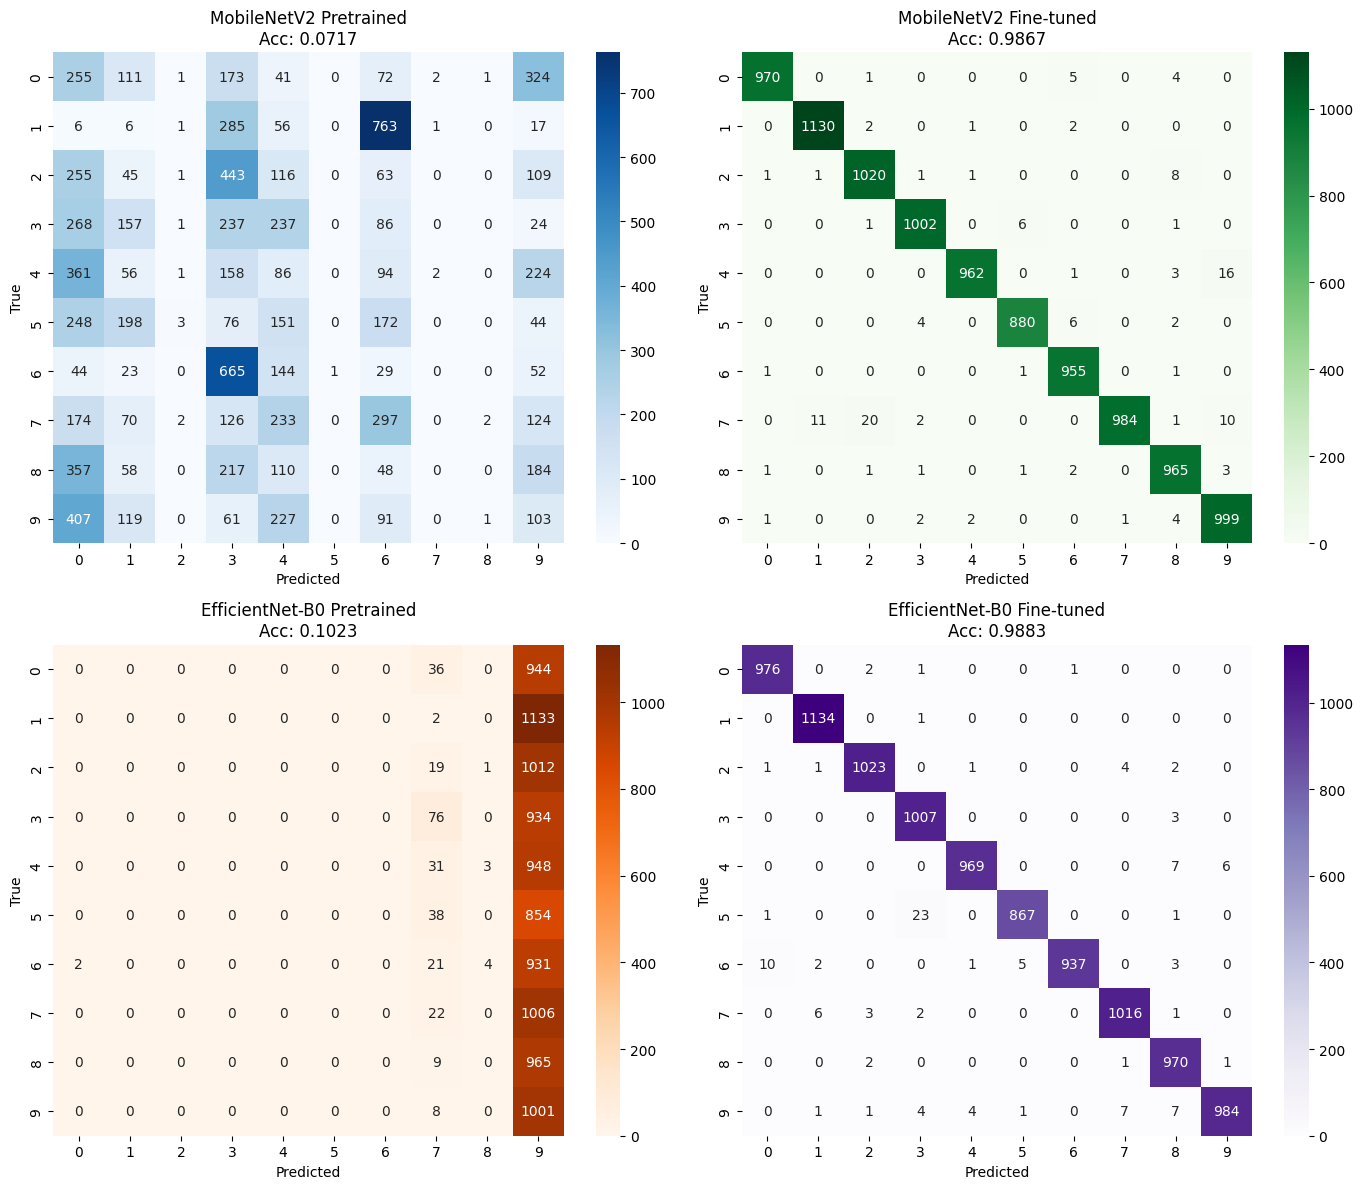


✓ Confusion matrices show improved performance after fine-tuning


In [13]:
from torchvision import models

# Save paths
mobilenet_save_path = os.path.join(os.getcwd(), 'mobilenet_v2_mnist_finetuned.pth')
efficientnet_save_path = os.path.join(os.getcwd(), 'efficientnet_b0_mnist_finetuned.pth')

def evaluate_model_full(model, test_loader):
    """Evaluate model with comprehensive metrics"""
    model.eval()
    model.to(device)
    
    all_preds, all_labels = [], []
    start_time = time.time()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    inference_time = time.time() - start_time
    all_preds, all_labels = np.array(all_preds), np.array(all_labels)
    
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_score': f1_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'n_params': sum(p.numel() for p in model.parameters()),
        'inference_time': inference_time
    }

# ============================================================================
# MOBILENETV2
# ============================================================================
print("\n" + "="*70)
print("MOBILENETV2")
print("="*70)

# Pretrained (zero-shot)
mobilenet_pretrained = models.mobilenet_v2(pretrained=True)
mobilenet_pretrained.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
mobilenet_pretrained.classifier[1] = nn.Linear(mobilenet_pretrained.last_channel, 10)
print("[1] Zero-shot evaluation...")
mobilenet_pretrained_metrics = evaluate_model_full(mobilenet_pretrained, test_loader)
print(f"    Accuracy: {mobilenet_pretrained_metrics['accuracy']:.4f}")

# Fine-tuned
if os.path.exists(mobilenet_save_path):
    print("[2] Loading fine-tuned model...")
    mobilenet_finetuned = models.mobilenet_v2(pretrained=False)
    mobilenet_finetuned.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet_finetuned.classifier[1] = nn.Linear(mobilenet_finetuned.last_channel, 10)
    checkpoint = torch.load(mobilenet_save_path)
    mobilenet_finetuned.load_state_dict(checkpoint['model_state_dict'])
    mobilenet_finetuned.to(device)
    mobilenet_finetuned.eval()
else:
    print("[2] Fine-tuning for 5 epochs...")
    mobilenet_finetuned = models.mobilenet_v2(pretrained=True)
    mobilenet_finetuned.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet_finetuned.classifier[1] = nn.Linear(mobilenet_finetuned.last_channel, 10)
    mobilenet_finetuned, _, _ = train_mnist_model(mobilenet_finetuned, train_loader, test_loader, epochs=5)
    torch.save({'model_state_dict': mobilenet_finetuned.state_dict()}, mobilenet_save_path)

mobilenet_finetuned_metrics = evaluate_model_full(mobilenet_finetuned, test_loader)
print(f"    Accuracy: {mobilenet_finetuned_metrics['accuracy']:.4f}")

# ============================================================================
# EFFICIENTNET-B0
# ============================================================================
print("\n" + "="*70)
print("EFFICIENTNET-B0")
print("="*70)

# Pretrained (zero-shot)
efficientnet_pretrained = models.efficientnet_b0(pretrained=True)
efficientnet_pretrained.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
efficientnet_pretrained.classifier[1] = nn.Linear(1280, 10)
print("[1] Zero-shot evaluation...")
efficientnet_pretrained_metrics = evaluate_model_full(efficientnet_pretrained, test_loader)
print(f"    Accuracy: {efficientnet_pretrained_metrics['accuracy']:.4f}")

# Fine-tuned
if os.path.exists(efficientnet_save_path):
    print("[2] Loading fine-tuned model...")
    efficientnet_finetuned = models.efficientnet_b0(pretrained=False)
    efficientnet_finetuned.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    efficientnet_finetuned.classifier[1] = nn.Linear(1280, 10)
    checkpoint = torch.load(efficientnet_save_path)
    efficientnet_finetuned.load_state_dict(checkpoint['model_state_dict'])
    efficientnet_finetuned.to(device)
    efficientnet_finetuned.eval()
else:
    print("[2] Fine-tuning for 5 epochs...")
    efficientnet_finetuned = models.efficientnet_b0(pretrained=True)
    efficientnet_finetuned.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    efficientnet_finetuned.classifier[1] = nn.Linear(1280, 10)
    efficientnet_finetuned, _, _ = train_mnist_model(efficientnet_finetuned, train_loader, test_loader, epochs=5)
    torch.save({'model_state_dict': efficientnet_finetuned.state_dict()}, efficientnet_save_path)

efficientnet_finetuned_metrics = evaluate_model_full(efficientnet_finetuned, test_loader)
print(f"    Accuracy: {efficientnet_finetuned_metrics['accuracy']:.4f}")

# ============================================================================
# CONFUSION MATRICES
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
cms = [
    (mobilenet_pretrained_metrics, 'MobileNetV2 Pretrained', 'Blues', (0, 0)),
    (mobilenet_finetuned_metrics, 'MobileNetV2 Fine-tuned', 'Greens', (0, 1)),
    (efficientnet_pretrained_metrics, 'EfficientNet-B0 Pretrained', 'Oranges', (1, 0)),
    (efficientnet_finetuned_metrics, 'EfficientNet-B0 Fine-tuned', 'Purples', (1, 1))
]

for metrics, title, cmap, (row, col) in cms:
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', 
                cmap=cmap, cbar=True, ax=axes[row, col])
    axes[row, col].set_title(f"{title}\nAcc: {metrics['accuracy']:.4f}")
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')

plt.tight_layout()
plt.show()

print("\n✓ Confusion matrices show improved performance after fine-tuning")

### Final Model Comparison

Comprehensive comparison of all 6 models on MNIST test set.

In [14]:
# Evaluate MLP and CNN
mlp_metrics = evaluate_model_full(mlp_model, test_loader)
cnn_metrics = evaluate_model_full(cnn_model, test_loader)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'MLP (Custom)',
        'Simple CNN',
        'MobileNetV2 (Pretrained)',
        'MobileNetV2 (Fine-tuned)',
        'EfficientNet-B0 (Pretrained)',
        'EfficientNet-B0 (Fine-tuned)'
    ],
    'Accuracy': [
        f'{mlp_metrics["accuracy"]:.4f}',
        f'{cnn_metrics["accuracy"]:.4f}',
        f'{mobilenet_pretrained_metrics["accuracy"]:.4f}',
        f'{mobilenet_finetuned_metrics["accuracy"]:.4f}',
        f'{efficientnet_pretrained_metrics["accuracy"]:.4f}',
        f'{efficientnet_finetuned_metrics["accuracy"]:.4f}'
    ],
    'F1-Score': [
        f'{mlp_metrics["f1_score"]:.4f}',
        f'{cnn_metrics["f1_score"]:.4f}',
        f'{mobilenet_pretrained_metrics["f1_score"]:.4f}',
        f'{mobilenet_finetuned_metrics["f1_score"]:.4f}',
        f'{efficientnet_pretrained_metrics["f1_score"]:.4f}',
        f'{efficientnet_finetuned_metrics["f1_score"]:.4f}'
    ],
    'Parameters': [
        f'{mlp_metrics["n_params"]:,}',
        f'{cnn_metrics["n_params"]:,}',
        f'{mobilenet_pretrained_metrics["n_params"]:,}',
        f'{mobilenet_finetuned_metrics["n_params"]:,}',
        f'{efficientnet_pretrained_metrics["n_params"]:,}',
        f'{efficientnet_finetuned_metrics["n_params"]:,}'
    ],
    'Inference Time (s)': [
        f'{mlp_metrics["inference_time"]:.2f}',
        f'{cnn_metrics["inference_time"]:.2f}',
        f'{mobilenet_pretrained_metrics["inference_time"]:.2f}',
        f'{mobilenet_finetuned_metrics["inference_time"]:.2f}',
        f'{efficientnet_pretrained_metrics["inference_time"]:.2f}',
        f'{efficientnet_finetuned_metrics["inference_time"]:.2f}'
    ]
})

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL COMPARISON
                       Model Accuracy F1-Score Parameters Inference Time (s)
                MLP (Custom)   0.9513   0.9513     24,380               2.18
                  Simple CNN   0.9870   0.9870    804,554               2.83
    MobileNetV2 (Pretrained)   0.0717   0.0482  2,236,106               3.92
    MobileNetV2 (Fine-tuned)   0.9867   0.9867  2,236,106               3.67
EfficientNet-B0 (Pretrained)   0.1023   0.0223  4,019,782               4.38
EfficientNet-B0 (Fine-tuned)   0.9883   0.9883  4,019,782               4.24
